# Churn Analysis

The dataset contains 4250 samples. Each sample contains 19 features and 1 boolean variable "churn" which indicates the class of the sample. 

- [EDA](#eda)
- [Data Transformation](#trans)
- [Modeling](#model)
    - [Hyperparameter Optimization](#hyper)
    - [Feature Selection](#feature)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SequentialFeatureSelector, mutual_info_classif
from sklearn.preprocessing import RobustScaler, TargetEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, f1_score

# EDA<a id='eda'><a>

In [2]:
df = pd.read_csv('train_churn.csv')
df

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

No missing data.

Remove prefix area_code_

In [4]:
df.area_code = df.area_code.str.replace('area_code_','').astype('int')

Convert yes/no to 1/0

In [5]:
df = df.replace({'yes':1, 'no':0})

In [6]:
df.select_dtypes('object').describe()

,state
count,4250
unique,51
top,WV
freq,139


50 states + DC

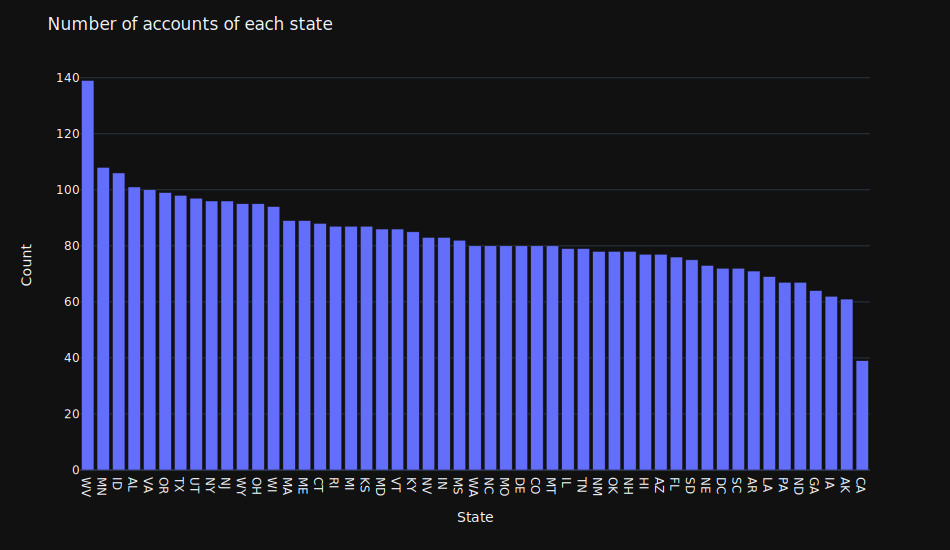

In [7]:
fig = px.bar(df.state.value_counts(), labels='')
fig.update_xaxes(title='State')
fig.update_yaxes(title='Count')
fig.update_layout(title='Number of accounts of each state',template='plotly_dark', height=550, width=950, 
                  showlegend=False)
fig.show('svg')

State with the most accounts is West Virginia (WV). State with the least accounts is California (CA)

In [8]:
acc_num_mean = df.state.value_counts().mean()
acc_num_sd = df.state.value_counts().std()
acc_num_min = df.state.value_counts().min()
acc_num_max = df.state.value_counts().max()

In [9]:
print(f'average:{round(acc_num_mean,2)}, sd:{round(acc_num_sd,2)}, min:{acc_num_min}, max:{acc_num_max}')

average:83.33, sd:15.0, min:39, max:139


Check churn rate for each state.

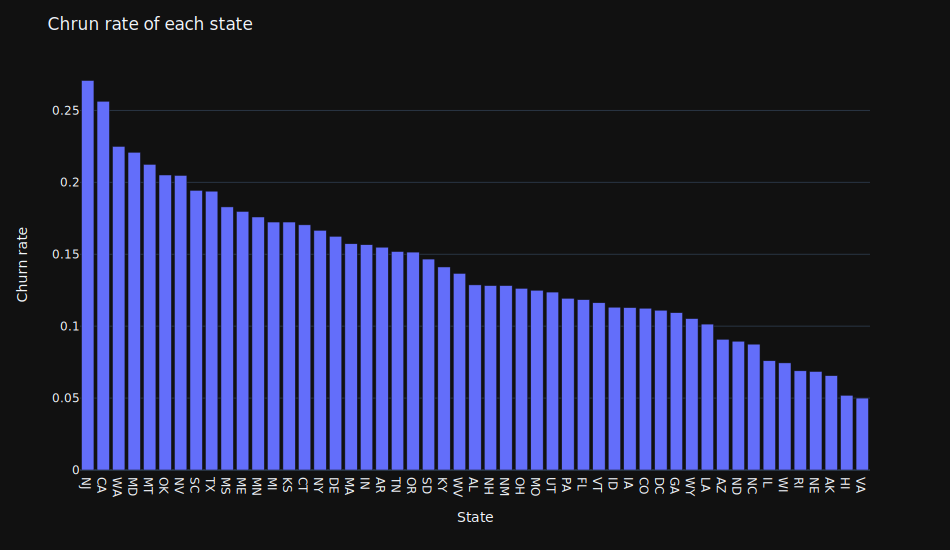

In [10]:
fig = px.bar(df.groupby('state').churn.mean().sort_values(ascending=False))
fig.update_xaxes(title='State')
fig.update_yaxes(title='Churn rate')
fig.update_layout(title='Chrun rate of each state',template='plotly_dark', height=550, width=950, 
                  showlegend=False)
fig.show('svg')

New jersey (NJ) has the highest churn rate, followed by CA. VA has the lowest churn rate.

_CA has the lowest number of accounts and the second highest churn rate._

__State has an effect on churn rate.__

Check area code of each state.

In [11]:
df.groupby('state').area_code.unique()

state
AK    [408, 415, 510]
AL    [408, 510, 415]
AR    [510, 415, 408]
AZ    [415, 408, 510]
CA    [415, 408, 510]
CO    [408, 415, 510]
CT    [415, 408, 510]
DC    [415, 510, 408]
DE    [408, 510, 415]
FL    [415, 510, 408]
GA    [408, 415, 510]
HI    [510, 415, 408]
IA    [408, 510, 415]
ID    [408, 415, 510]
IL    [408, 415, 510]
IN    [415, 408, 510]
KS    [408, 415, 510]
KY    [415, 408, 510]
LA    [408, 415, 510]
MA    [510, 415, 408]
MD    [408, 510, 415]
ME    [415, 510, 408]
MI    [415, 510, 408]
MN    [408, 510, 415]
MO    [415, 510, 408]
MS    [408, 415, 510]
MT    [510, 408, 415]
NC    [408, 415, 510]
ND    [408, 415, 510]
NE    [408, 415, 510]
NH    [510, 408, 415]
NJ    [415, 408, 510]
NM    [510, 415, 408]
NV    [415, 510, 408]
NY    [415, 408, 510]
OH    [415, 408, 510]
OK    [415, 408, 510]
OR    [408, 415, 510]
PA    [415, 408, 510]
RI    [415, 408, 510]
SC    [415, 408, 510]
SD    [408, 415, 510]
TN    [415, 408, 510]
TX    [415, 510, 408]
UT    [415, 408, 510]
VA  

Each state has 3 area codes, 408, 415, 510.

In [12]:
df.area_code.value_counts()

area_code
415    2108
408    1086
510    1056
Name: count, dtype: int64

In [13]:
df.groupby('area_code').churn.agg(['mean', 'std'])

,mean,std
area_code,,
408,0.139963,0.347109
415,0.136148,0.343027
510,0.150568,0.357797


Each area code has similar churn rate.

Check values for other numerical features.

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
account_length,4250.0,100.236235,39.698401,1.0,73.0000,100.00,127.0000,243.00
area_code,4250.0,436.816000,42.183514,408.0,408.0000,415.00,415.0000,510.00
international_plan,4250.0,0.093176,0.290714,0.0,0.0000,0.00,0.0000,1.00
voice_mail_plan,4250.0,0.261647,0.439583,0.0,0.0000,0.00,1.0000,1.00
number_vmail_messages,4250.0,7.631765,13.439882,0.0,0.0000,0.00,16.0000,52.00
total_day_minutes,4250.0,180.259600,54.012373,0.0,143.3250,180.45,216.2000,351.50
total_day_calls,4250.0,99.907294,19.850817,0.0,87.0000,100.00,113.0000,165.00
total_day_charge,4250.0,30.644682,9.182096,0.0,24.3650,30.68,36.7500,59.76
total_eve_minutes,4250.0,200.173906,50.249518,0.0,165.9250,200.70,233.7750,359.30
total_eve_calls,4250.0,100.176471,19.908591,0.0,87.0000,100.00,114.0000,170.00


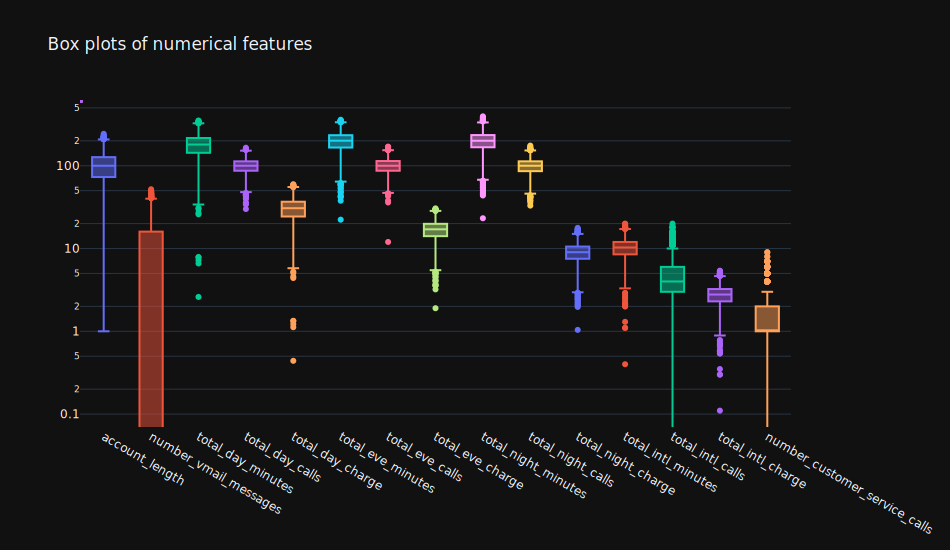

In [15]:
fig = go.Figure()
for i in df.drop(['area_code','international_plan','voice_mail_plan','churn'], axis=1).select_dtypes('number').columns:
    fig.add_trace(go.Box(y=df[i], name=df[i].name))
fig.update_yaxes(type="log")
fig.update_layout(title='Box plots of numerical features', showlegend=False, template='plotly_dark',
                 width=950, height=550)
fig.show('svg')

There are no extreme values.

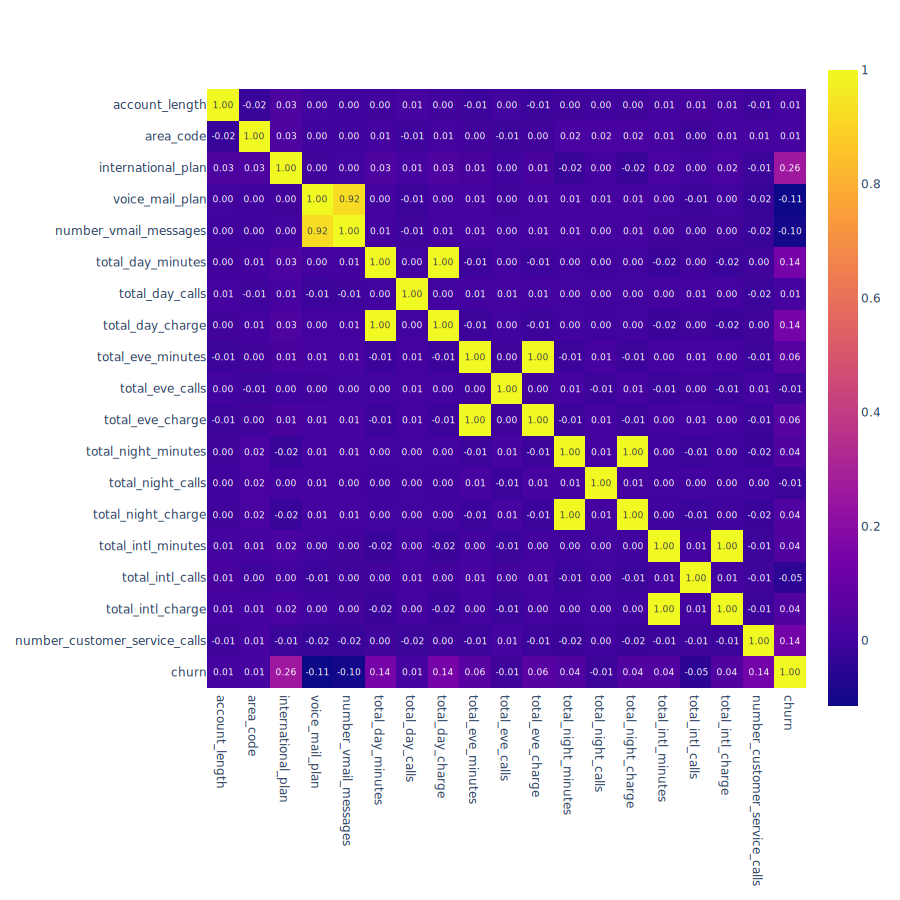

In [16]:
fig = px.imshow(df.drop('state', axis=1).corr('kendall'), text_auto='.2f', width= 900, height=900)
fig.show('svg')

Features with high correlations are international_plan, total_day_minutes,  total_day_charge, and number_customer_service_calls.

***

# Data Transformation<a id='trans'><a>

In [17]:
X = df.drop('churn', axis=1)
y = df.churn

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [19]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [20]:
numeric_features = X.drop('area_code', axis=1).select_dtypes(include=['number']).columns
numeric_transformer = RobustScaler()

OH_transformer = OneHotEncoder(drop='first', handle_unknown="ignore")
Target_transformer = TargetEncoder(random_state=0)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("oh", OH_transformer, ['area_code']),
        ('target', Target_transformer, ['state'])
    ]
)

# Modeling<a id='model'><a>

## Logistic Regression

Use cv-score of logistic regression as baseline.

In [21]:
steps = [('prep', preprocessor), ('log', LogisticRegression())]
pipeline_log =  Pipeline(steps)
score_log = cross_val_score(pipeline_log, X_train, y_train, scoring='f1', cv=kf)
score_log

array([0.27419355, 0.28571429, 0.35460993, 0.23809524, 0.34042553])

In [22]:
score_log.mean(), score_log.std()

(0.2986077066379057, 0.04314864935189651)

## Gradient Boost (Light GBM)

In [23]:
steps = [('prep', preprocessor), ('lgb', lgb.LGBMClassifier(objective='binary'))]
pipeline_lgb = Pipeline(steps)
score_lgb = cross_val_score(pipeline_lgb, X_train, y_train, scoring='f1', cv=kf)
score_lgb

[LightGBM] [Info] Number of positive: 383, number of negative: 2337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 2720, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140809 -> initscore=-1.808588
[LightGBM] [Info] Start training from score -1.808588
[LightGBM] [Info] Number of positive: 383, number of negative: 2337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2578
[LightGBM] [Info] Number of data points in the train set: 2720, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140809 -> initscore=-1.808588
[LightGBM] [Info] Start training from score -1.808588
[LightGBM] [Info] Nu

array([0.84916201, 0.86046512, 0.86338798, 0.7607362 , 0.85393258])

In [24]:
score_lgb.mean(), score_lgb.std()

(0.8375367772366025, 0.03872025594214348)

The cv-score of LGB is a lot better compared to logistic regression as expected.

## Hyperparameter optimization<a id='hyper'><a>

In [25]:
def lgb_eval(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 50)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 30)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 0.1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_split_gain = trial.suggest_float('min_split_gain', 0, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
    
    lgb_param_grid = {'objective':'binary', 'num_leaves':num_leaves,'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_split_gain':min_split_gain,
                      'min_child_weight':min_child_weight, 'min_child_samples':min_child_samples,'verbosity':-1}
    
    steps = [('prep', preprocessor), ('lgb', lgb.LGBMClassifier(**lgb_param_grid))]
    pipeline_lgbc = Pipeline(steps)
    score = cross_val_score(pipeline_lgbc, X_train, y_train, scoring='f1', cv=kf)
    return score.mean()

In [26]:
sampler = optuna.samplers.TPESampler(seed=0)
lgb_study = optuna.create_study(direction='maximize', sampler=sampler)
lgb_study.optimize(lgb_eval, n_trials=100)

[I 2024-04-30 21:43:30,634] A new study created in memory with name: no-name-97db5de2-caa1-448f-ad66-68c90803f5cb
[I 2024-04-30 21:43:31,061] Trial 0 finished with value: 0.8262921036501654 and parameters: {'num_leaves': 32, 'n_estimators': 386, 'max_depth': 19, 'learning_rate': 0.05449286946785972, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_split_gain': 0.9636627605010293, 'min_child_weight': 3.8960710363751994, 'min_child_samples': 40}. Best is trial 0 with value: 0.8262921036501654.
[I 2024-04-30 21:43:31,595] Trial 1 finished with value: 0.7587093583522613 and parameters: {'num_leaves': 31, 'n_estimators': 327, 'max_depth': 28, 'learning_rate': 0.007112895459206716, 'reg_alpha': 0.08712929970154071, 'reg_lambda': 0.02021839744032572, 'subsample': 0.8342936470924586, 'colsample_bytree': 0.780375183440352, 'min_split_gain': 0.8700121482468192, 'min_child_weight': 9.788321588104363, 'm

[I 2024-04-30 21:43:36,010] Trial 17 finished with value: 0.8223633321269113 and parameters: {'num_leaves': 24, 'n_estimators': 293, 'max_depth': 21, 'learning_rate': 0.08383637966300728, 'reg_alpha': 0.8357239491209825, 'reg_lambda': 0.7915475155192613, 'subsample': 0.21588017369391793, 'colsample_bytree': 0.8810324970926882, 'min_split_gain': 0.8685975197075075, 'min_child_weight': 4.864127049352723, 'min_child_samples': 33}. Best is trial 11 with value: 0.8318223057615477.
[I 2024-04-30 21:43:36,529] Trial 18 finished with value: 0.69491407408172 and parameters: {'num_leaves': 43, 'n_estimators': 217, 'max_depth': 30, 'learning_rate': 0.035733763293633536, 'reg_alpha': 0.6841004353388055, 'reg_lambda': 0.8668704365205967, 'subsample': 0.39772629815171834, 'colsample_bytree': 0.2807117017458658, 'min_split_gain': 0.0022652556785879296, 'min_child_weight': 4.81742285332948, 'min_child_samples': 26}. Best is trial 11 with value: 0.8318223057615477.
[I 2024-04-30 21:43:36,739] Trial 19 

[I 2024-04-30 21:43:41,389] Trial 35 finished with value: 0.7898038600620548 and parameters: {'num_leaves': 22, 'n_estimators': 464, 'max_depth': 19, 'learning_rate': 0.004003364879409485, 'reg_alpha': 0.4815113766846627, 'reg_lambda': 0.17311384733143753, 'subsample': 0.5525480485139391, 'colsample_bytree': 0.8642304806322393, 'min_split_gain': 0.9990640326790882, 'min_child_weight': 6.550190687524724, 'min_child_samples': 31}. Best is trial 11 with value: 0.8318223057615477.
[I 2024-04-30 21:43:41,588] Trial 36 finished with value: 0.8169077649087562 and parameters: {'num_leaves': 17, 'n_estimators': 310, 'max_depth': 25, 'learning_rate': 0.09408893695053507, 'reg_alpha': 0.37881244001312403, 'reg_lambda': 0.5008444062183635, 'subsample': 0.6401518425873086, 'colsample_bytree': 0.6696115172037631, 'min_split_gain': 0.8121617572189302, 'min_child_weight': 7.774668736877838, 'min_child_samples': 22}. Best is trial 11 with value: 0.8318223057615477.
[I 2024-04-30 21:43:41,871] Trial 37 

[I 2024-04-30 21:43:46,447] Trial 52 finished with value: 0.8306846993911368 and parameters: {'num_leaves': 46, 'n_estimators': 351, 'max_depth': 29, 'learning_rate': 0.0699919108580687, 'reg_alpha': 0.2886926236665391, 'reg_lambda': 0.6291063379279216, 'subsample': 0.3022162182628981, 'colsample_bytree': 0.9001161815547551, 'min_split_gain': 0.5061595050006235, 'min_child_weight': 1.2103297152499721, 'min_child_samples': 26}. Best is trial 38 with value: 0.8338802180401383.
[I 2024-04-30 21:43:46,981] Trial 53 finished with value: 0.820023386599216 and parameters: {'num_leaves': 46, 'n_estimators': 348, 'max_depth': 25, 'learning_rate': 0.0654949622439577, 'reg_alpha': 0.3744943056263485, 'reg_lambda': 0.6327417813124717, 'subsample': 0.11075452891657517, 'colsample_bytree': 0.9126430757074078, 'min_split_gain': 0.5206254287742461, 'min_child_weight': 1.0503257434445221, 'min_child_samples': 26}. Best is trial 38 with value: 0.8338802180401383.
[I 2024-04-30 21:43:47,253] Trial 54 fin

[I 2024-04-30 21:43:51,590] Trial 69 finished with value: 0.8274693223047169 and parameters: {'num_leaves': 44, 'n_estimators': 256, 'max_depth': 18, 'learning_rate': 0.09441290505465397, 'reg_alpha': 0.41235715716575605, 'reg_lambda': 0.7391523771170823, 'subsample': 0.14879574198677192, 'colsample_bytree': 0.9174115557247076, 'min_split_gain': 0.2398745436038342, 'min_child_weight': 1.9569826763463185, 'min_child_samples': 30}. Best is trial 57 with value: 0.8370871577140028.
[I 2024-04-30 21:43:51,837] Trial 70 finished with value: 0.8116869554177397 and parameters: {'num_leaves': 41, 'n_estimators': 315, 'max_depth': 25, 'learning_rate': 0.09695714139018603, 'reg_alpha': 0.5917114859852988, 'reg_lambda': 0.7913772458467155, 'subsample': 0.12424620026982675, 'colsample_bytree': 0.807584382767774, 'min_split_gain': 0.559388551218329, 'min_child_weight': 1.5724804488990198, 'min_child_samples': 9}. Best is trial 57 with value: 0.8370871577140028.
[I 2024-04-30 21:43:52,159] Trial 71 f

[I 2024-04-30 21:44:02,235] Trial 86 finished with value: 0.8321867361344992 and parameters: {'num_leaves': 48, 'n_estimators': 316, 'max_depth': 19, 'learning_rate': 0.014023145794250076, 'reg_alpha': 0.046901900871446835, 'reg_lambda': 0.6425109733881115, 'subsample': 0.3373495386077038, 'colsample_bytree': 0.9814683932287743, 'min_split_gain': 0.25978513497375494, 'min_child_weight': 0.15852003434234696, 'min_child_samples': 18}. Best is trial 84 with value: 0.8404702174603804.
[I 2024-04-30 21:44:03,630] Trial 87 finished with value: 0.8368583102290967 and parameters: {'num_leaves': 48, 'n_estimators': 287, 'max_depth': 17, 'learning_rate': 0.018314780967359563, 'reg_alpha': 0.07271942091330406, 'reg_lambda': 0.6971857763944533, 'subsample': 0.2756612774402319, 'colsample_bytree': 0.8916339794011099, 'min_split_gain': 0.19054606724198017, 'min_child_weight': 0.1258125672797123, 'min_child_samples': 20}. Best is trial 84 with value: 0.8404702174603804.
[I 2024-04-30 21:44:04,715] Tr

In [27]:
best_trial = lgb_study.best_trial
best_params = best_trial.params
best_params['objective'] = 'binary'
best_params['verbosity'] = -1

In [28]:
print(f'Best score: {best_trial.value}')

Best score: 0.8404702174603804


In [29]:
best_params

{'num_leaves': 47,
 'n_estimators': 290,
 'max_depth': 21,
 'learning_rate': 0.01364890909097178,
 'reg_alpha': 0.05417777803878375,
 'reg_lambda': 0.5664561439754155,
 'subsample': 0.33782113040188827,
 'colsample_bytree': 0.9817091518906537,
 'min_split_gain': 0.3052663398526373,
 'min_child_weight': 0.10296953149619872,
 'min_child_samples': 20,
 'objective': 'binary',
 'verbosity': -1}

In [30]:
steps = [('prep', preprocessor), ('lgb', lgb.LGBMClassifier(**best_params))]
pipeline_lgbc = Pipeline(steps)

In [31]:
pipeline_lgbc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_i...
                                                  TargetEncoder(random_state=0),
                                                  ['state'])])),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.9817091518906537,
                                learning_rate=0.01364890909097178, max_depth=21,
                                min_child_weight=0.10296953149619872,
                                min_split_gain=0.3052663398526373,
                                n_estimators=290, num_leaves=47,
                                objective='binary',
                                reg_alpha=0.05417777803878375,
                                reg_lambda=0.5664561439754155,
                                subsample=0.33782113040188827, verbosity=-1))])

In [32]:
y_pred = pipeline_lgbc.predict(X_test)
f1_score(y_test, y_pred)

0.834862385321101

In [33]:
importance_df = pd.DataFrame({'feature': pipeline_lgbc.named_steps.prep.get_feature_names_out(), 
                              'importance': pipeline_lgbc.named_steps.lgb.feature_importances_})
importance_df.feature = importance_df.feature.str.replace('.*__','', regex=True)
importance_df = importance_df.sort_values('importance')

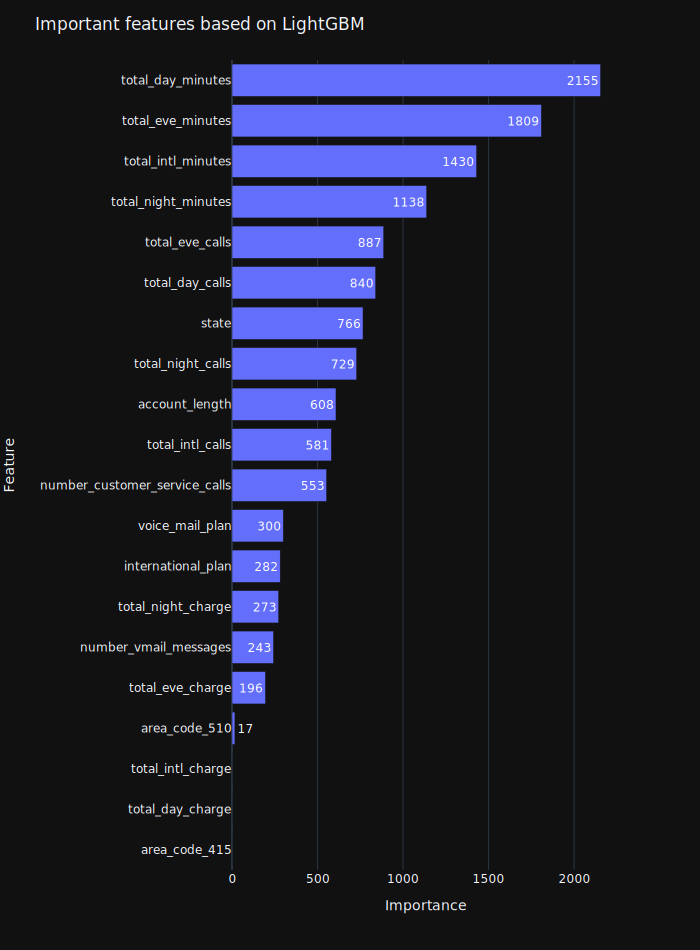

In [34]:
fig = px.bar(x=importance_df.importance, y=importance_df.feature, text_auto='d', width=700, height=950)
fig.update_layout(template = 'plotly_dark', title='Important features based on LightGBM',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('svg')

## Feature Selection<a id='feature'><a>

### Select k best

In [35]:
steps = [('prep', preprocessor), ('selectkbest', SelectKBest(mutual_info_classif)), ('lgb', lgb.LGBMClassifier(**best_params))]
pipeline_mi =  Pipeline(steps)
k = [k for k in range(1, 21)]
parameters = {'selectkbest__k':k}
lgb_mi_cv = GridSearchCV(pipeline_mi, param_grid=parameters, scoring='f1', cv=kf)
lgb_mi_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_e...
                                                       learning_rate=0.01364890909097178,
                                                       max_depth=21,
                                                       min_child_weight=0.10296953149619872,
                                                       min_split_gain=0.3052663398526373,
                                                       n_estimators=290,
                                                       num_leaves=47,
                                                       objective='binary',
                                                       reg_alpha=0.05417777803878375,
                                                       reg_lambda=0.5664561439754155,
                                                       subsample=0.33782113040188827,
                                                       verbosity=-1))]),
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19,
                                            20]},
             scoring='f1')

In [36]:
lgb_mi_cv.best_score_, lgb_mi_cv.best_params_

(0.8404702174603804, {'selectkbest__k': 20})

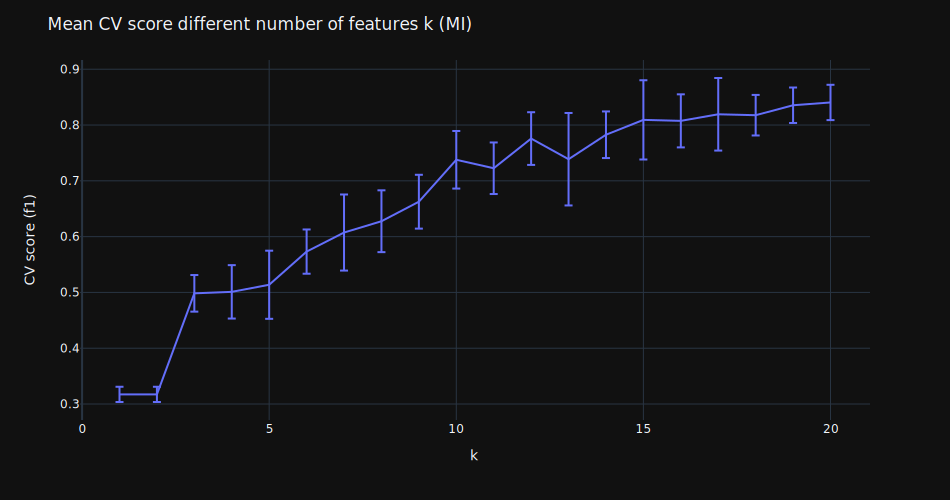

In [37]:
score_mean = lgb_mi_cv.cv_results_['mean_test_score']
score_std = lgb_mi_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly_dark', title='Mean CV score different number of features k (MI)',
                  yaxis_title='CV score (f1)', width=950, height=500)

fig.show('svg')

Score plateaus around 18-20. Feature selection with mutual info cannot reduce dimension in this case.

### RFE

In [38]:
steps = [('prep', preprocessor), 
         ('rfe', RFE(lgb.LGBMClassifier(**best_params))),
         ('lgb', lgb.LGBMClassifier(**best_params))
        ]
pipeline_rfe = Pipeline(steps)
k = [k for k in range(1, 21)]
parameters = {'rfe__n_features_to_select':k}
lgb_rfe_cv = GridSearchCV(pipeline_rfe, param_grid=parameters, scoring='f1', cv=kf)
lgb_rfe_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num',
                                                                         RobustScaler(),
                                                                         Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_e...
                                                       learning_rate=0.01364890909097178,
                                                       max_depth=21,
                                                       min_child_weight=0.10296953149619872,
                                                       min_split_gain=0.3052663398526373,
                                                       n_estimators=290,
                                                       num_leaves=47,
                                                       objective='binary',
                                                       reg_alpha=0.05417777803878375,
                                                       reg_lambda=0.5664561439754155,
                                                       subsample=0.33782113040188827,
                                                       verbosity=-1))]),
             param_grid={'rfe__n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19,
                                                       20]},
             scoring='f1')

In [39]:
lgb_rfe_cv.best_score_, lgb_rfe_cv.best_params_

(0.8404702174603804, {'rfe__n_features_to_select': 18})

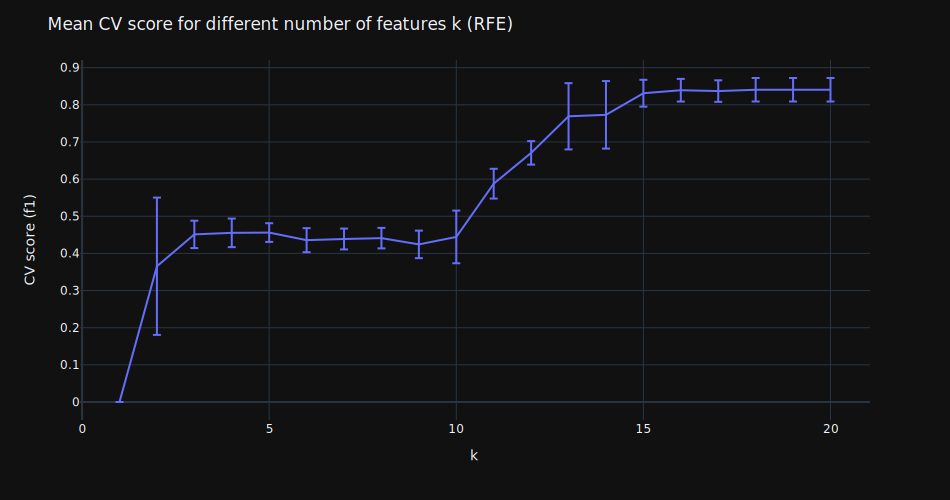

In [40]:
score_mean = lgb_rfe_cv.cv_results_['mean_test_score']
score_std = lgb_rfe_cv.cv_results_['std_test_score']

fig = px.line(x=k, y=score_mean, error_y=score_std)

fig.update_xaxes(title_text='k')

fig.update_layout(template = 'plotly_dark', title='Mean CV score for different number of features k (RFE)',
                  yaxis_title='CV score (f1)', width=950, height=500)

fig.show('svg')

Score plateaus around __15__. More features have diminishing return and may lead to overfit.

In [41]:
steps = [('prep', preprocessor), 
         ('rfe', RFE(lgb.LGBMClassifier(**best_params), n_features_to_select=15)),
         ('lgb', lgb.LGBMClassifier(**best_params))
        ]
pipeline_rfe_15 = Pipeline(steps)
pipeline_rfe_15.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_i...
                     n_features_to_select=15)),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.9817091518906537,
                                learning_rate=0.01364890909097178, max_depth=21,
                                min_child_weight=0.10296953149619872,
                                min_split_gain=0.3052663398526373,
                                n_estimators=290, num_leaves=47,
                                objective='binary',
                                reg_alpha=0.05417777803878375,
                                reg_lambda=0.5664561439754155,
                                subsample=0.33782113040188827, verbosity=-1))])

In [42]:
y_pred = pipeline_rfe_15.predict(X_test)
f1_score(y_test, y_pred)

0.834862385321101

In [43]:
importance_df = pd.DataFrame({'feature': pipeline_rfe_15.named_steps.prep.get_feature_names_out()[pipeline_rfe_15.named_steps.rfe.support_], 
                              'importance': pipeline_rfe_15.named_steps.lgb.feature_importances_})
importance_df.feature = importance_df.feature.str.replace('.*__','', regex=True)
importance_df = importance_df.sort_values('importance')

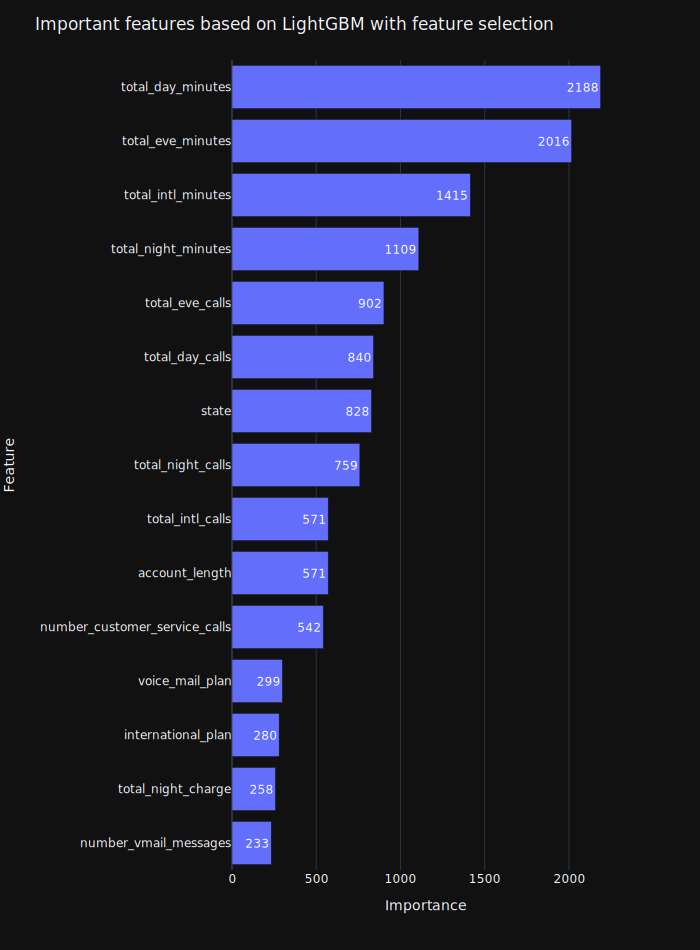

In [44]:
fig = px.bar(x=importance_df.importance, y=importance_df.feature, text_auto='d', width=700, height=950)
fig.update_layout(template = 'plotly_dark', title='Important features based on LightGBM with feature selection',
                  yaxis_title='Feature',xaxis_title='Importance')
fig.show('svg')

In [45]:
set(pd.Series(pipeline_rfe_15.named_steps.prep.get_feature_names_out()).str.replace('.*__','',regex=True))-set(importance_df.feature)

{'area_code_415',
 'area_code_510',
 'total_day_charge',
 'total_eve_charge',
 'total_intl_charge'}

The dropped features are area_code_415, area_code_510, total_day_charge, total_eve_charge, and total_intl_charge

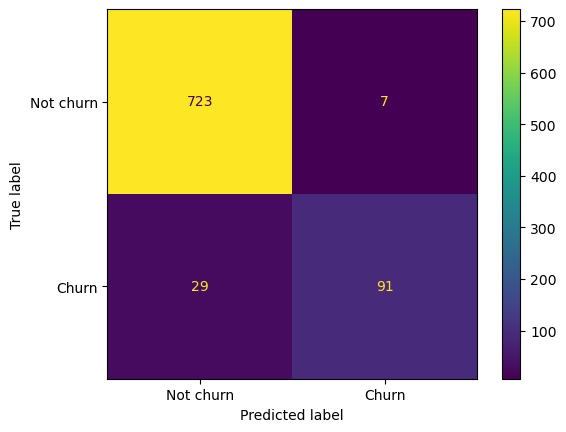

In [46]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not churn', 'Churn'])
cmd.plot()
plt.show()

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       730
           1       0.93      0.76      0.83       120

    accuracy                           0.96       850
   macro avg       0.95      0.87      0.91       850
weighted avg       0.96      0.96      0.96       850



In [48]:
y_prob = pipeline_rfe_15.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob.T[1])
roc_auc = auc(fpr, tpr)
prec, recall, thresholds = precision_recall_curve(y_test, y_prob.T[1])
average_precision=average_precision_score(y_test, y_prob.T[1])
f1 = 2*prec[:-1]*recall[:-1]/(prec[:-1]+recall[:-1])
f1_max = f1.max()
threshold_max = thresholds[f1.argmax()]

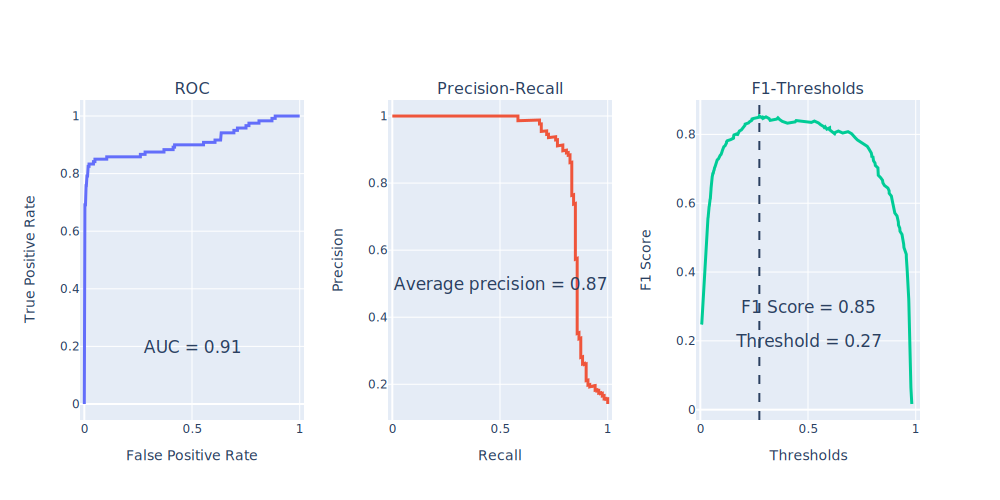

In [49]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("ROC", "Precision-Recall", 'F1-Thresholds'), 
                    horizontal_spacing=0.1)

fig.append_trace(go.Scatter(x=fpr, y=tpr, mode='lines', line={'width':3}), row=1, col=1)
fig.update_xaxes(title_text="False Positive Rate", range=[-0.02,1.02], row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
fig.add_annotation(x=0.5, y=0.2, text=f'AUC = {roc_auc:.2f}', showarrow=False,  font={'size':17}, row=1, col=1)

fig.add_trace(go.Scatter(x=recall, y=prec, mode='lines', line={'width':3}), row=1, col=2)
fig.update_xaxes(title_text="Recall", range=[-0.02,1.02], row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)
fig.add_annotation(x=0.5, y=0.5, text=f'Average precision = {average_precision:.2f}', showarrow=False,  font={'size':17}, row=1, col=2)

fig.add_trace(go.Scatter(x=thresholds, y=f1, mode='lines', line={'width':3}), row=1, col=3)
fig.update_xaxes(title_text="Thresholds", range=[-0.02,1.02], row=1, col=3)
fig.update_yaxes(title_text="F1 Score", row=1, col=3)
fig.add_vline(x=threshold_max, line_width=2, line_dash="dash", row=1, col=3)
fig.add_annotation(x=0.5, y=0.3, text=f'F1 Score = {f1_max:.2f}', showarrow=False,  font={'size':17}, row=1, col=3)
fig.add_annotation(x=0.5, y=0.2, text=f'Threshold = {threshold_max:.2f}', showarrow=False,  font={'size':17}, row=1, col=3)

fig.update_layout(showlegend=False,
                  template='plotly',
                  width=1000, height=500)
fig.show('svg')

## Learning curve

In [50]:
fractions = [0.1, 0.33, 0.55, 0.78, 1.]
train_size, train_scores, test_scores = learning_curve(pipeline_rfe_15, X_train, y_train, train_sizes=fractions, 
                                                       scoring='f1', cv=kf)

In [51]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

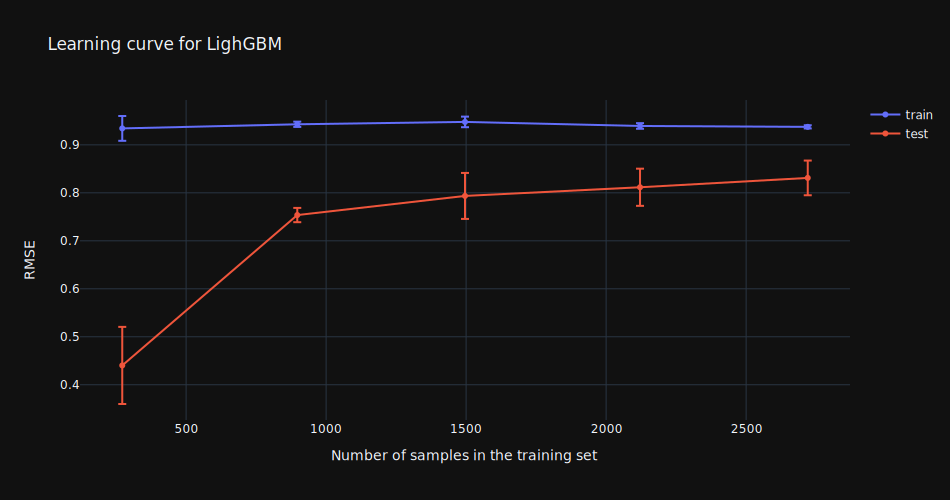

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_size, y=train_scores_mean, name='train',
                         error_y=dict(type='data', array=train_scores_std,visible=True)))
fig.add_trace(go.Scatter(x=train_size, y=test_scores_mean, name='test',
                         error_y=dict(type='data', array=test_scores_std,visible=True)))
fig.update_xaxes(title='Number of samples in the training set')
fig.update_yaxes(title='RMSE')
fig.update_layout(title='Learning curve for LighGBM', template='plotly_dark', width=950, height=500)
fig.show('svg')

More samples may slight increase the score.